In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from simulators import SimulatorLinePattern

  0%|          | 0/2 [00:00<?, ?it/s]

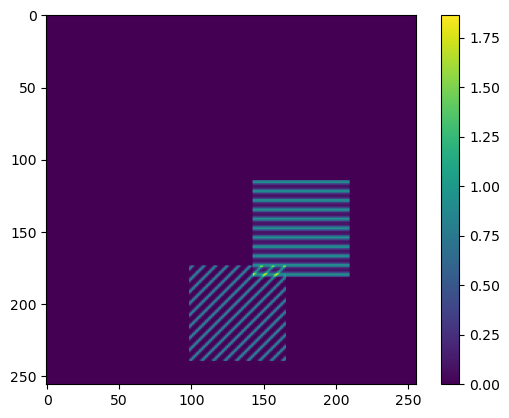

In [13]:
sim = SimulatorLinePattern(bounds = None)
samples = sim.sample(2)
t = samples[0]['mu']
plt.imshow(t)
plt.colorbar()

In [354]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 16, num_params = 5, varnames = 'z')
        self.CNN = torch.nn.Sequential(
            torch.nn.LazyConv2d(4, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.MLP = torch.nn.Sequential(
            torch.nn.LazyLinear(1024), torch.nn.ReLU(),
            torch.nn.LazyLinear(1024), torch.nn.ReLU(),
            torch.nn.LazyLinear(16)
        )

    def forward(self, A, B):
        mu = A['mu']
        f = self.CNN(mu.unsqueeze(1))
        f = torch.flatten(f, start_dim = 1)
        f = self.MLP(f)
        logratios = self.logratios(f, B['z'])
        return logratios
    
net = Network()

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [355]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', max_epochs = 20, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [359]:
samples = sim.sample(2048)
dl = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0], batch_size = 64)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [360]:
network = Network()

In [361]:
trainer.fit(network, dl)

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /Users/cweniger/Documents/swyft/notebooks/primer/lightning_logs/version_94/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 91.8 K
1 | CNN       | Sequential             | 0     
2 | MLP       | Sequential             | 0     
-----------------------------------------------------
91.8 K    Trainable params
0         Non-trainable params
91.8 K    Total params
0.367     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 13it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [362]:
prior_samples = sim.sample(N = 10000, targets = ['z'])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [363]:
#obs = samples[2]
#plt.imshow(obs['mu'])

In [364]:
logratios = trainer.infer(network, obs, prior_samples)

Predicting: 3it [00:00, ?it/s]

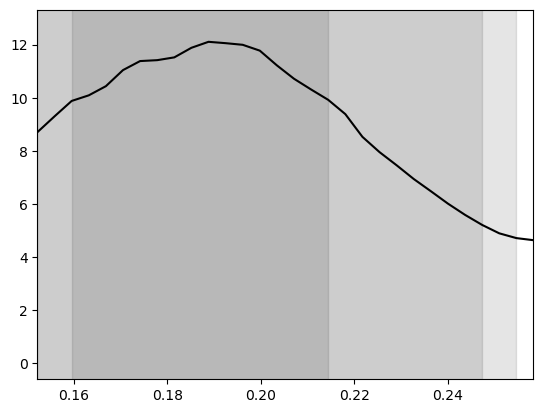

In [365]:
swyft.plot_1d(logratios, "z[4]", ax = plt.gca(), smooth = 1, bins = 30)

In [341]:
#bounds = swyft.lightning.bounds.get_rect_bounds(logratios, threshold = 1e-6)
bounds = swyft.collect_rect_bounds(logratios, 'z', (5,), threshold = 1e-3)